**For deploying/operationalizing this model, we can do following this:**
1. deploy the machine learning model as a Webapp/API on Microsoft Azure (using docker). save and load the model from perfromance perspective and see the predicted result on Web App.
2. we can also create web app through flask and pass input data to prediction function and get predictions.
3. There are different cloud platforms like AWS sagemaker, microsoft azure for deploying ML models.

reading dataset file

In [1]:
import pandas as pd
df = pd.read_csv('../input/toy-dataset/toy_dataset.csv')

In [2]:
df.shape

(150000, 6)

In [3]:
df.head()

,Number,City,Gender,Age,Income,Illness
0,1,Dallas,Male,41,40367.0,No
1,2,Dallas,Male,54,45084.0,No
2,3,Dallas,Male,42,52483.0,No
3,4,Dallas,Male,40,40941.0,No
4,5,Dallas,Male,46,50289.0,No


drop number index column

In [4]:
df.drop('Number', axis=1, inplace=True )

In [5]:
df.isna().sum(axis=0)

City       0
Gender     0
Age        0
Income     0
Illness    0
dtype: int64

In [6]:
df['City'].value_counts()

New York City      50307
Los Angeles        32173
Dallas             19707
Mountain View      14219
Austin             12292
Boston              8301
Washington D.C.     8120
San Diego           4881
Name: City, dtype: int64

**convert gender catogorical values to numeric binary values**

In [7]:
df.loc[df['Gender']=='Male','Gender'] = 1

In [8]:
df.loc[df['Gender']=='Female','Gender'] = 0

**One hot encode City variable to prepare data into numeric format for ML modelling to make accurate predictions**

In [9]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb_results = lb.fit_transform(df['City'])
new_df = pd.DataFrame(lb_results, columns=lb.classes_)

In [10]:
df = pd.concat([df, new_df], axis = 1)

**Converting Target class categorical values to numeric binary values**

In [11]:
df.loc[df['Illness'] == 'Yes','Illness'] = 1

In [12]:
df.loc[df['Illness'] == 'No','Illness'] = 0

In [13]:
df.drop(['City'], axis=1, inplace=True)
df.head()

,Gender,Age,Income,Illness,Austin,Boston,Dallas,Los Angeles,Mountain View,New York City,San Diego,Washington D.C.
0,1,41,40367.0,0,0,0,1,0,0,0,0,0
1,1,54,45084.0,0,0,0,1,0,0,0,0,0
2,1,42,52483.0,0,0,0,1,0,0,0,0,0
3,1,40,40941.0,0,0,0,1,0,0,0,0,0
4,1,46,50289.0,0,0,0,1,0,0,0,0,0


In [14]:
y = df['Illness']
df.drop(['Illness'], axis=1, inplace=True)
X = df

**split dataset into training at testing set**

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)


train logistic regression

In [16]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
model = lm.fit(X_train, y_train)


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [17]:
predictions = model.predict(X_test)

Confusion matrix:
 [[45551     0]
 [ 3949     0]]


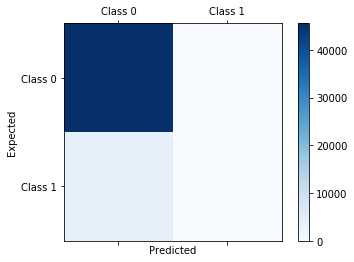

In [18]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

**above confusion matrix shows our true positives cases are zero. Hence we can say that model is biased towards zero and not performing well for class 1 i.e having illness**

**Applying oversampling techniques**

In [19]:
from sklearn.utils import resample

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_ill = X[X.Illness==0]
ill = X[X.Illness==1]


In [20]:
# upsample minority
ill_upsampled = resample(ill,
                          replace=True, # sample with replacement
                          n_samples=len(not_ill), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_ill, ill_upsampled])

# check new class counts
upsampled.Illness.value_counts()

1    103343
0    103343
Name: Illness, dtype: int64

In [21]:
df_oversample = upsampled
y_train = upsampled.Illness
X_train=upsampled.drop(['Illness'], axis=1)


from sklearn.ensemble import RandomForestClassifier
lm = RandomForestClassifier(n_estimators = 100, oob_score = True,n_jobs = 1,random_state =50)
model = lm.fit(X_train, y_train)
predictions=model.predict(X_test)


0.85248
AUC: 0.507


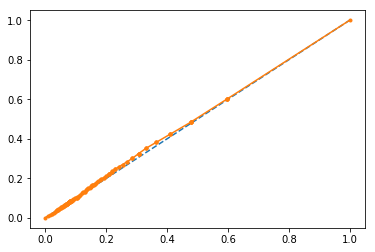

In [22]:

from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score
from matplotlib import pyplot
print(accuracy_score(y_test, predictions))

# predict probabilities
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()


oversampling not performing well

Confusion matrix:
 [[31720  2798]
 [ 2734   248]]


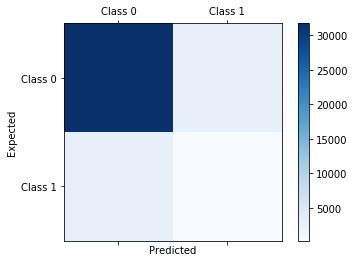

In [23]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

undersample not performing well.
Use  Synthetic Minority Oversampling Technique

**visualizing features importances**

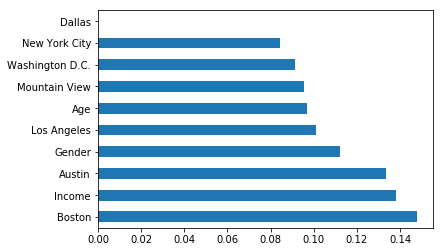

In [24]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

xgbmodel = XGBClassifier()
xgbmodel.fit(X_train, y_train)
feat_importances = pd.Series(xgbmodel.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')